In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("messages.csv",encoding='latin-1')


In [ ]:
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3802 entries, 0 to 3801
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  3724 non-null   object
 1   message  3802 non-null   object
 2   label    3802 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 89.2+ KB


In [ ]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (3802, 3)


In [ ]:
df.isnull().sum()

subject    78
message     0
label       0
dtype: int64

In [ ]:
df['label'].value_counts()

0    3162
1     640
Name: label, dtype: int64

In [ ]:
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 83.0 %
Spam Email Ratio that is 1 label: 17.0 %


In [ ]:
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [ ]:
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [ ]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
   
# Replace numeric characters with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [ ]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [ ]:
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2483
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1569
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0,1435,1144
3,risk,colleague researching differing degrees risk p...,0,324,220
4,request book information,earlier morning phone friend mine living south...,0,1046,719


In [ ]:
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [ ]:
df['clean_length'] = df.message.str.len()
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856,2483
1,NaN,"lang classification grimes , joseph e . barbar...",0,1800,1569
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas ( satamas @ umab...,0,1435,1144
3,risk,colleague researching differing degrees risk p...,0,324,220
4,request book information,earlier morning phone friend mine living south...,0,1046,719


In [ ]:
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 12450939
Cleaned Length: 10082759
Total Words Removed: 2368180


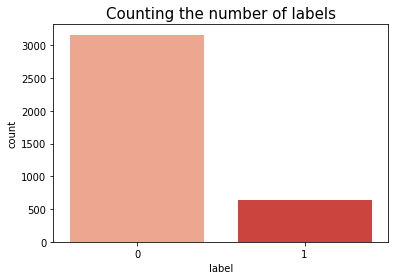

0    3162
1     640
Name: label, dtype: int64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(df.label.value_counts())

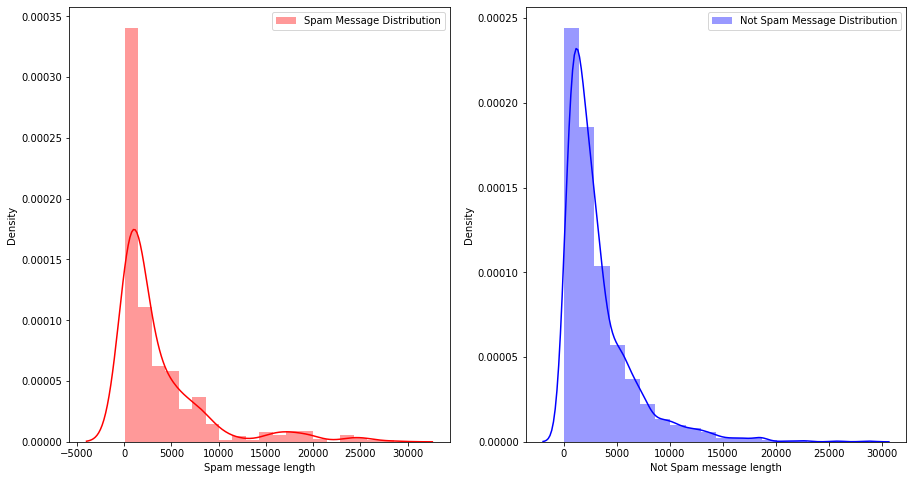

In [ ]:
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

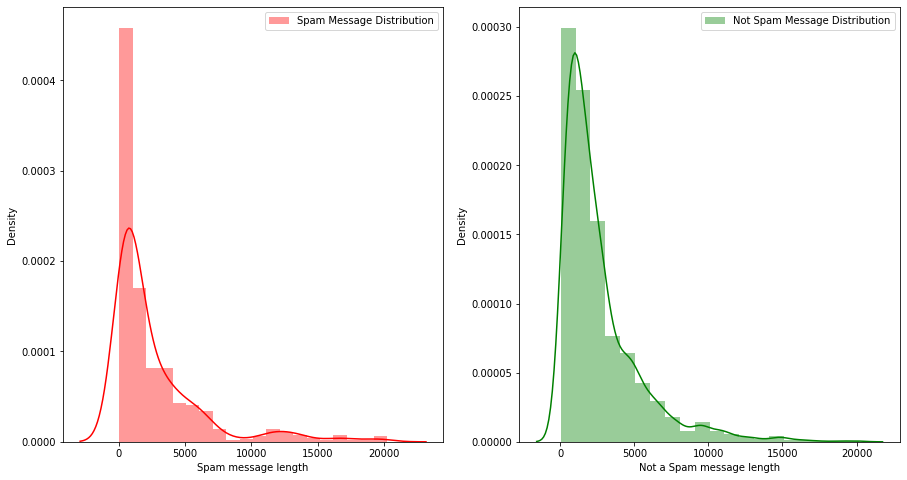

In [ ]:
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

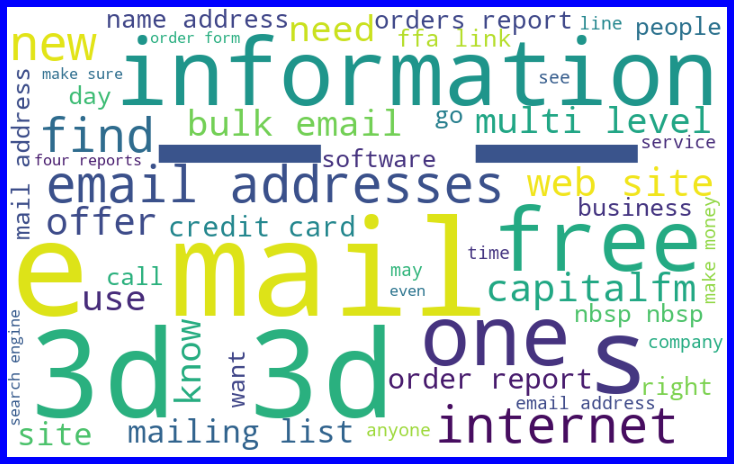

In [ ]:
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

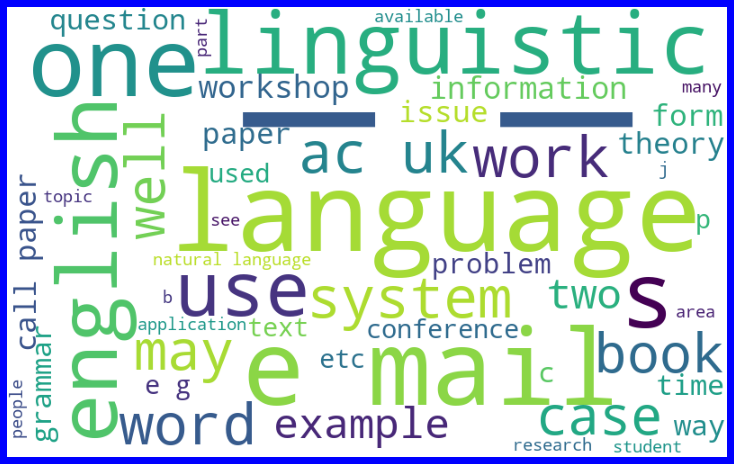

In [ ]:
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label


tf_vec = TfidfVectorizer()

#naive = MultinomialNB()

SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [ ]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)         #test_size=0.20 random_state=42 test_size=0.15

#naive.fit(X_train,Y_train)
#y_pred= naive.predict(x_test)

SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9936908517350158


In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,

In [ ]:
# Checking Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       774
           1       1.00      0.97      0.98       177

    accuracy                           0.99       951
   macro avg       1.00      0.98      0.99       951
weighted avg       0.99      0.99      0.99       951



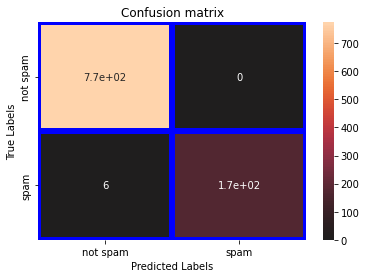

In [ ]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

In [ ]:
#We see SVM to perform the best.
#save the best model.
import pickle
filename='Email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()